# Non-Harmonic Distortion in a Quantized Sinusoid <br /> <br /> (Tsividis' Paradox Part I)
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>
<br />

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import scipy.special as ss
from scipy.io import wavfile
import IPython
import ipywidgets as widgets

In [3]:
plt.rcParams["figure.figsize"] = (14,4)

In [4]:
# helper functions

def play_sound(SF, s, volume=1):
    # play a sound with a volume factor
    x = np.copy(s) * volume
    return IPython.display.Audio(x, rate=SF, normalize=False)  

def stem(x, color='tab:blue'):
    # stem with chosen color
    markerline, stemlines, baseline = plt.stem(x, use_line_collection=True, basefmt='k');
    markerline.set_color(color)
    stemlines.set_color(color)

## Your classic A/D converter

 * $x(t)$ bandlimited to $F_s/2$
 * sample at $F_s$ Hz
 * uniform quantization with $M$ levels

<center>
<img src="sbq.png" style="width: 1200px;"/> 
</center>

## Uniform scalar quantization

 * $M$-level uniform scalar quantizer
 * $q: \mathbb{R} \rightarrow \{\hat{x}_0, \ldots, \hat{x}_{M-1}\}$
 
 
 
 * non-overload region: $[-1,1]$
 * quantization step: $\Delta = 2/M$

In [5]:
def quantize(x, M):
    if M == 0:
        return x
    elif M % 2 == 0:
        # using a mid-riser quantizer
        M = M / 2
        k = np.floor(x * M)
        k = np.maximum(np.minimum(k, M-1), -M)
        return (k + 0.5) / M
    else:
        # using a deadzone quantizer
        k = np.round(np.abs(x) * M / 2)
        k = np.minimum((M - 1) / 2, k)
        return (np.sign(x) * k / M * 2 )

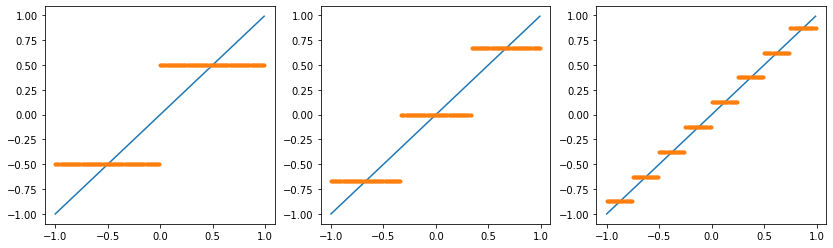

In [6]:
x = np.arange(-1, 1, .01)
for ix, M in enumerate([2, 3, 8]):
    plt.subplot(1, 3, ix+1)
    plt.plot(x,x);    
    plt.plot(x, quantize(x, M), '.');

## High-resolution hypothesis

<center>
<img src="linearized.png" style="width: 1200px;"/> 
</center>

 * $e[n]$ white noise uncorrelated with $x[n]$
 * $\sigma_e[n] = \Delta^2/12$
    

## Tsividis' paradox


<center><img src="sbq.png" style="width: 800px;"/></center>

 * sampling and quantization are memoryless: they can be swapped


## Tsividis' paradox

 * sampling and quantization are memoryless: they can be swapped

<center>
<img src="sbq.png" style="width: 800px;"/> 
<img src="qbs.png" style="width: 800px;"/> 
</center>

<center>
but $\mathcal{Q}$ discontinuous so $\hat{x}(t)$ no longer bandlimited  $~~\Longrightarrow~~$ aliasing!
</center>

## Harmonic vs non-harmonic distortion

Consider a musical note with fundamental frequency $f_0$:

 * **harmonic distortion** modifies the spectral content at integer multiples of $f_0$ (typical of "natural" saturation/clipping)
 * **non-harmonic distortion** introduces spectral lines elsehwere (typical of aliasing)
 

Long story short:
 * harmonic distortion: bearable, if we really have to
 * non-harmonic distortion: unbearable because totally unnatural

## Harmonic vs non-harmonic distortion: example

<br />

In [7]:
fs, A, B, M = 8000, 3, 31, 9
x = np.zeros(M * fs)

# progessively harder clipping
for n in range(M, 1, -1):
    x[(M-n)*fs:(M+1-n)*fs] = np.clip(np.sin(1 + (2 * np.pi / B) * A * (np.arange(0, fs) % B)), -n/M, n/M) * M / n
play_sound(fs, x, volume=0.3)

In [8]:
# progressively coarser quantization
for n in range(M, 0, -1):
    x[(M-n)*fs:(M+1-n)*fs] = quantize(np.sin(1 + (2 * np.pi / B) * A * (np.arange(0, fs) % B)), 2**n)
play_sound(fs, x, volume=0.3)

## Ravel's Bolero

<center>
<img width="1000" src="bolero_diff.jpg">
</center>


In [9]:
def play_quantized(excerpt, levels):
    SF, s = wavfile.read(excerpt + '.wav')
    return play_sound(SF, quantize(s / 32767, levels))

audio_files = ['boleroA', 'boleroZ']
def multiplay_quantized(file_list, levels=None, description=None):
    outs = [widgets.Output() for f in file_list]
    for ix, file in enumerate(file_list):
        with outs[ix]:
            if levels is not None:
                M = levels[ix]
                quant = str(M) + ' levels'
            else:
                M = 0 
                quant = 'full res'
            print(description[ix] if description is not None else file + ', ' + quant)
            M = 0 if not levels else levels[ix]
            display(play_quantized(file, M))
    return widgets.HBox(outs)

In [10]:
multiplay_quantized(['boleroA', 'boleroZ'])

## Ravel's Bolero

<br /><br />
<center>
<img width="1200" src="bolero_wav.png">
</center>

## Ravel's Bolero

 * performances have an excursion of 100dBs or more
 * 16-bit audio covers about 96dBs
 * ... but vinyl is no better: about 70dB dynamic range

## Aside #1: oreloB

<img width="480" style="float: right;" src="orelob.jpg">

Bolero is much louder at the end but vinyls suffer from _end of side_ distortion:
 * rotational speed constant, but inner grooves shorter
 * reading speed gets slower
 * recorded wavelengths become shorter<br/> and comparable to stylus size
 * groove slope gets too steep for tracking
 
Solution: oreloB, a vinyl that plays backwards

## Back to Ravel's Bolero on CD

<img width="800" style="float: right;" src="bolero_wav.png">

 * clearly the beginning spans a much smaller<br />number of quantization levels than the end
 * the high-resolution hypothesis may not hold

In [13]:
multiplay_quantized(['boleroM', 'boleroM'], levels=[2**16, 2**8])

In [14]:
multiplay_quantized(['boleroA', 'boleroA'], levels=[2**16, 2**8])

## Numerical Experiments

The opening flute in the Bolero is close to a pure sinusoid, so let's focus on quantizing a sine wave.

 * using the conventional sampling + quantization setup
 * $x(t) = \sin(2\pi f_0 t)$, sampled at $F_s$ and $f_0 = \frac{A}{B}F_s$ with $A$ and $B$ coprime
 
 
 * $x[n] = \sin\left(2\pi\frac{A}{B}n\right)$
 
 
 * $x[n]$ will be periodic with period $B$ and it will span $A$ cycles over $B$ samples
 * natural Fourier representation: DFS
 * $\mathbf{X}\in \mathbb{C}^B$
 * single nonzero coefficient $X[A]$

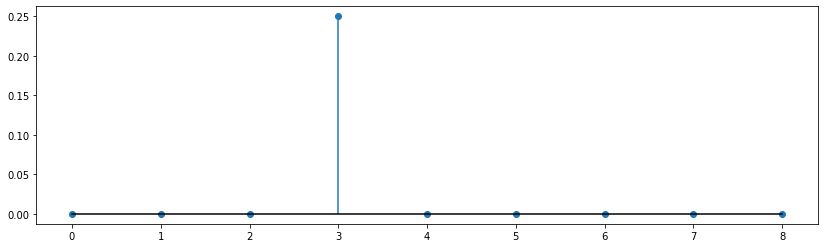

In [35]:
def quantized_sinusoid(A, B, M=0, initial_phase=1):
    # add an initial phase non commensurable with pi to eliminate quantization of zero values
    x = np.sin(initial_phase + 2 * np.pi * ((A * np.arange(0, B)) % B) / B)
    qx = quantize(x, M)
    return {
        'original' : x, 
        'quantized' : qx, 
        # square magnitude of the normalized DFS for positive frequencies
        'DFS' : (np.abs(np.fft.fft(qx))[:int(np.ceil(B/2))] / B ) ** 2 
    }

stem(quantized_sinusoid(3, 17)['DFS'])

## Introducing quantization

 * $\mathbf{x} \rightarrow \hat{\mathbf{x}}$
 * $\hat{\mathbf{x}}$ sitll periodic with a period of $B$ samples
 

 * harmonic distortion will affects the DFS coefficient whose index is a multiple of $A$;
 * non-harmonic distortion will affect the other coefficients
 
 
First note in the Bolero is a $C_5$, i.e. 523.25Hz. At $F_s=44.1$KHz we can pick $B=257$ and $A=3$. 

In [36]:
def find_nhd(A, dfs, full=False):
    # zero out harmonic components to highlight non-harmonic content
    N = int(np.ceil(len(dfs) / 2)) if full else len(dfs)
    nhd = np.copy(dfs[:N])
    nhd[::A] = 0
    return max(nhd), nhd

In [37]:
def show_nhd(A=5, B=257, M=0):
    s = quantized_sinusoid(A, B, int(M))
    peak, nhd = find_nhd(A, s['DFS'])
    
    plt.subplot(1, 2, 1)    
    plt.plot(s['original']);
    plt.plot(s['quantized']);
    plt.title('signal')
    
    plt.subplot(1, 2, 2)    
    stem(s['DFS'])
    plt.title('DFS')
    
    plt.figure()
    stem(nhd)
    plt.ylim(0, 0.0002)
    plt.title('non-harmonic components, max=' + str(peak))

In [38]:
display(widgets.interactive(show_nhd, M=widgets.Dropdown(options=['2', '3', '4', '128' ]), A=(1, 11), B=widgets.fixed(257)))

interactive(children=(IntSlider(value=5, description='A', max=11, min=1), Dropdown(description='M', options=('…

## Searching for the worst case

 * try to get a sense for how bad non-harmonic distortion can get
 * let's iterate over all non-reducible $A/B$ ratios between $0$ and $1/2$ 
 
 
**Farey sequence** of order $N$ is the sequence of _non-reducible_ fractions in the unit interval with denominator smaller or equal than $N$

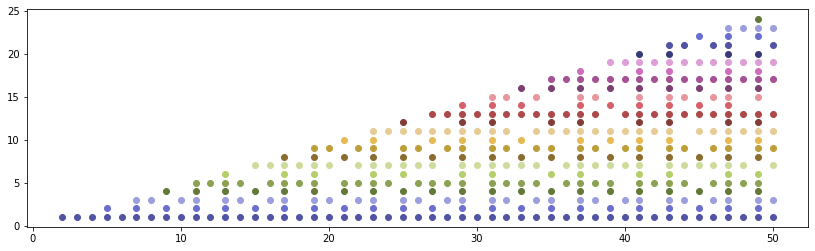

In [39]:
def farey_sequence(n):
    """Build the order-N Farey sequence up to 1/2."""
    farey = []
    (a, b, c, d) = (0, 1, 1, n)
    while (c <= n):
        k = (n + b) // d
        (a, b, c, d) = (c, d, k * c - a, k * d - b)
        farey.append((a, b))
        if a/b >= 0.5:
            break
    return farey


for (a, b) in farey_sequence(50):
    plt.plot(b, a, 'o', color=plt.cm.tab20b(a % 20))

In [40]:
def find_max_nhd(N, M=2, parametric=False):
    max_value = (0, 0, 0)
    for (A, B) in farey_sequence(N):
        peak, _ = find_nhd(A, quantized_sinusoid(A, B, M)['DFS'])
        plt.plot(B if parametric else (A / B), peak, 'o', color=plt.cm.tab20b(A % 20))
        if peak > max_value[0]:
            max_value = (peak, A, B)
    plt.title(f'max value is {max_value[0]}, frequency {max_value[1]}/{max_value[2]}')

## Non-harmonic distortion for Farey ratios

Maximum square magnitude of non-harmonic DFS coefficient as a function of $B$ and parametrized in $A$

![title](nhd.png)

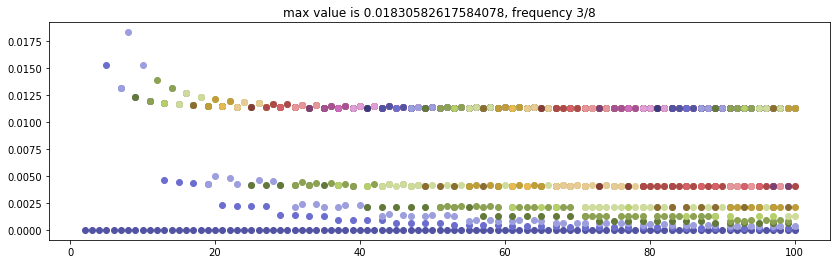

In [41]:
find_max_nhd(100, 2, parametric=True)

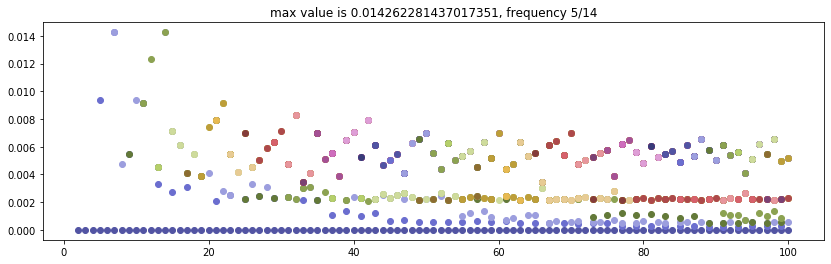

In [42]:
find_max_nhd(100, 3, parametric=True)

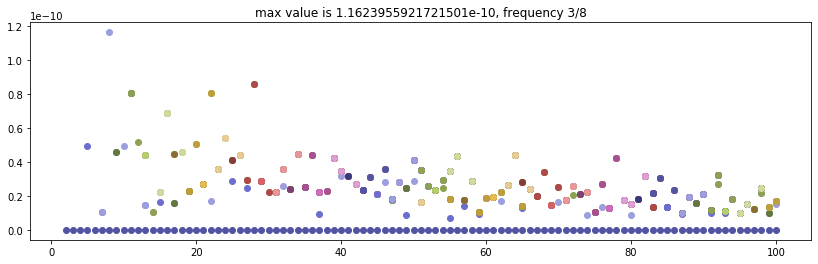

In [43]:
find_max_nhd(100, 32768, parametric=True)

From a different perspective, the non-parametrized plots show that, as we increase the normalized frequency of the sinusoid, the max non-harmonic distortion seems to cluster around discrete steps. We will see an explanation for this pattern later.

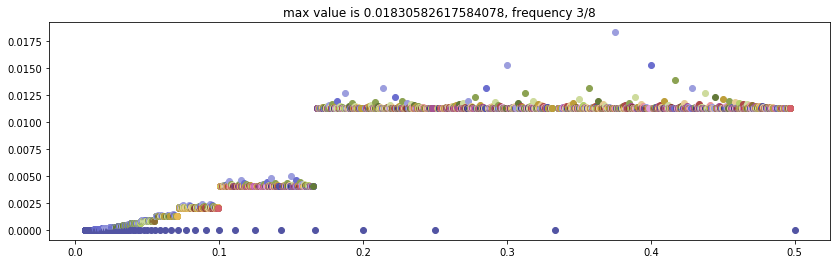

In [44]:
find_max_nhd(150, 2)

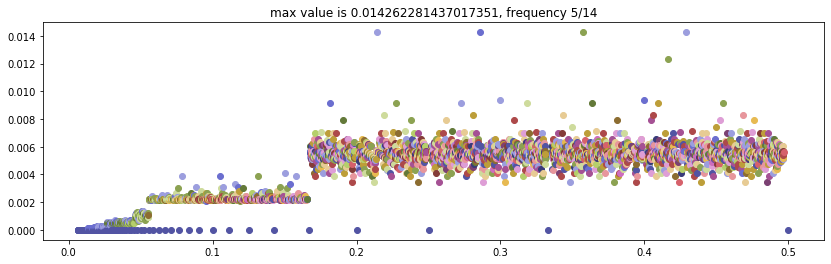

In [45]:
find_max_nhd(150, 3)

## Theoretical Analysis

### 3.1. Some DSP archeology

In 1947, Clavier, Panter and Grieg published the paper ["Distortion in a Pulse Count Modulation System"](https://ieeexplore.ieee.org/document/5059539), which provides some fundamental insight into the problem. Consider an analog input signal of the form $x(t) = \sin(t)$; in the quantizer-before-sampler circuit, the discrete-amplitude, continuous-time signal $\hat{x}(t)$ would look like so:

In [ ]:
t = np.arange(0, 2 * np.pi, 0.001)
plt.plot(t, quantize(np.sin(t), 15));

<img width="200" style="float: right; margin: 10px;" src="clavier.jpg">

Clavier et al. decompose this piecewise-constant periodic waveform as the sum of $N$ pairs of rectangular steps of appropriate width, as shown in the figure reproduced here. Then, using a Fourier series expansion, they express $\hat{x}(t)$ in closed form as:

$$
  \hat{x}(t) = \sum_{h=1}^{N} \sum_{k=0}^{\infty} \frac{4}{\pi N (2k+1)} \cos\left[(2k+1)\arcsin\left(\frac{2h-1}{2N}\right) \right]\sin((2k+1)t)
$$

This corresponds roughly to the effects of applying a deadzone quantizer with $M = 2N - 1$ levels to the input; we can verify the expression numerically like so (and notice the unavoidable Gibbs phenomenon at the points of discontinuity):

In [ ]:
def quantized_sinusoid_fs(N, terms=1000):
    t = np.arange(0, 2 * np.pi, 0.001)
    x = np.zeros(len(t))
    for h in range(1, N):
        for k in range(0, terms):
            x = x + np.cos((2 * k + 1) * np.arcsin((2 * h - 1) / N / 2)) * np.sin((2 * k + 1) * t) / (2 * k + 1)
    x = x * 4 / np.pi / N
    return t, x

In [ ]:
plt.plot(*quantized_sinusoid_fs(8));

There are some slight technicalities that should be addressed to adapt Clavier's analysis to our problem, since the paper only considers deadzone quantizers and uses a slightly different definition for the quantization function than we do; however we will not pursue this approach further since these issues will be addressed by the more general method presented below. 

The fundamental piece of intuition provided by this analysis is however correct: **the quantized continuous-time waveform contains harmonics at all odd multiples of the input's frequency** and, therefore, spectral lines beyond the Nyquist frequency will be aliased by the sampler.

### 3.2. Quantization noise analysis

Robert Gray's 1990 paper ["Quantization Noise Spectra"](https://ieeexplore.ieee.org/document/59924) provides an extremely in-depth analysis of the distortion introduced by quantization from a discrete-time perspective. In the case of uniform quantization, Gray generalizes Clavier's Fourier series approach by considering the expression for the _normalized quantization error_

$$
    \eta(x) = \frac{q(x) - x}{\Delta} =  \frac{q(x) - x}{2/M} \quad \in [-0.5, 0.5].
$$

When the input $x$ is in the non-overload region of an $M$-level quantizer, $\eta(x)$ is a periodic function with period $M/2$, as shown here:

In [ ]:
x = np.arange(-1, 1, .001)
for ix, M in enumerate([2, 3, 8]):
    plt.subplot(1, 3, ix+1)
    e = (quantize(x, M) - x) / (2 / M)
    plt.plot(x, e);    
    plt.plot(x, e, '.');

The normalized quantization error, therefore, can be expressed as a Fourier series; the expression turns out to be

$$
    \eta(x) = \sum_{k=1}^{\infty} \frac{(-1)^{kM}}{\pi k}\sin\left(\pi k M x\right)
$$

where the term $(-1)^{kM}$ is identically one for mid-riser quantizers and alternates in sign for deadzone quantizers.

We can verify the relatively quick convergence of the FS numerically:

In [ ]:
def nqe_fs(x, M, terms=1000):
    e = np.zeros(len(x))
    s = [1, -1 if M % 2 == 1 else 1]
    for k in range(1, terms):
        e = e + s[k % 2] * np.sin(np.pi * k * x * M) / (np.pi * k)
    return x, e

In [ ]:
for ix, M in enumerate([2, 3, 8]):
    plt.subplot(1, 3, ix+1)
    plt.plot(*nqe_fs(np.arange(-1, 1, .01), M))

#### Quantization noise for a sinusoidal input

Let's now consider the standard sampling before quantization setup; assume the input is a pure sinusoid and that the signal entering the quantizer is $x[n] = \sin(\omega_0 n + \theta)$ with $0 \le \omega_0 < 2\pi$. The associated normalized quantization error signal is $\eta[n] = \eta(\sin(\omega_0 n + \theta))$ and we are interested in computing its spectrum. 

The Fourier series expansion of the error function is more conveniently expressed using complex exponentials:

$$
    \eta(x) = \sum_{k \neq 0} \frac{(-1)^{kM}}{j2\pi k}e^{j\pi k M x}.
$$

If we replace $x$ by $\sin(\omega_0 n + \theta)$ we end up with terms of the form $e^{j \alpha \sin \beta}$; these can be expanded in terms of Bessel functions using the so-called Jacobi-Anger formula:

$$
    e^{j \alpha \sin \omega} = \sum_{m=-\infty}^{\infty} J_m(\alpha)e^{j\omega m}.
$$

Since Bessel functions are even or odd according to whether their order is even or odd, we have:

$$
\begin{align*}
    \eta[n] = \eta(\sin(\omega_0 n + \theta)) &= \sum_{k \neq 0} \frac{(-1)^{kM}}{j2\pi k}e^{j\pi k M \sin(\omega_0 n + \theta)} \\
      &= \sum_{k \neq 0} \frac{(-1)^{kM}}{j2\pi k} \sum_{m=-\infty}^{\infty} J_m(\pi k M)e^{j (2m+1)\theta} e^{j (2m+1)\omega_0 n} \\
      &= \sum_{m=-\infty}^{\infty} \left[ e^{j (2m+1)\theta} \sum_{k = 1}^{\infty} \frac{(-1)^{kM}}{j\pi k}J_{2m+1}(\pi k M) \right] e^{j (2m+1)\omega_0 n} \\ \\
      &= \sum_{\varphi \in \Omega(\omega_0)} b(\varphi) e^{j \varphi n}
\end{align*} 
$$

The expression shows that the normalized error is the sum of a set of complex exponentials where

 * the frequencies belong to a set $\Omega(\omega_0)$ defined by equivalence class $\{(2m+1)\omega_0 \mod 2\pi\}_{m \in \mathbb{Z}}$; this set includes all the odd multiples of the fundamental frequency (that appear in Clavier's analysis), aliased over the $[0, 2\pi]$ interval;
 
 * for each frequency $\varphi \in \Omega(\omega_0)$ the magnitude of the relative complex exponential is given by
 $$
   b(\varphi) = \sum_{m \in I(\varphi)} \left[ e^{j (2m+1)\theta} \sum_{k = 1}^{\infty} \frac{(-1)^{kM}}{j\pi k}J_{2m+1}(\pi k M) \right] \label{eq:vector_ray}  \tag{1}
 $$
 where $I(\varphi)$ is the set of integers $m$ for which $(2m+1)\omega_0 \equiv \varphi \mod 2\pi$.
 
This representation allows us to express the Power Spectral Density of the normalized quantization error for a full-range sinusoidal input as 

$$
    P_{\omega_0}(e^{j\omega}) = \sum_{\varphi \in \Omega(\omega_0)} |b(\varphi)|^2 \delta(\omega - \varphi).
$$

#### Rational normalized frequency

If $\omega_0 = 2\pi(A/B)$, with $A$ and $B$ coprime integers, the set $\Omega(\omega_0)$ is finite; using modular arithmetic we can show that 

$$
\Omega\left(2\pi\frac{A}{B}\right) = \left\{\frac{2i\pi}{B}\right\} \quad \mbox{with} \begin{cases}
    i = 0, 1, 2, \ldots, B-1 & \mbox{if $A$ or $B$ even} \\
    i = 1, 3, 5, \ldots, B-1 & \mbox{if $A$ and $B$ odd} 
    \end{cases}
$$
 
and

$$
    I\left(\frac{2i\pi}{B}\right) = \{i[A]^{-1}_{B} + pB\}_{p \in \mathbb{Z}}
$$

where $[A]^{-1}_{B}$ is the modular inverse of $A$, i.e. $A[A]^{-1}_{B} \equiv 1 \mod B$.
    
In this case, the power spectral density of the error contains a finite number of spectral lines at multiples of $2\pi/B$ and the power associated to each line $|b(2i\pi/B)|^2$ should correspond to the square magnitude of the $i$-th coefficient of the $B$-point DFS of the error signal.

The following function computes an approximation of the coefficients $b(2i\pi/B)$ for $\omega_0 = 2\pi(A/B)$, scaled to represent the non-normalized quantization error:

In [ ]:
def nqe_sin_psd(A, B, M, phase=1):
    s = [1, -1 if M % 2 == 1 else 1]
    b = np.zeros(B, dtype=complex)
    m_lim, k_lim = max(1500, 2 * B), 600
    for m in range(-m_lim, m_lim):
        c = 0
        for k in range(1, k_lim):
            c += s[k % 2] * ss.jv(2 * m + 1, np.pi * k * M) / k
        c /= 1j * np.pi
        b[((2 * m + 1) * A) % B] += c * np.exp(1j * phase * (2 * m + 1))
    # undo error normalization to obtain the real error PSD
    b = np.abs(b  * (2 / M)) ** 2
    print('Max NHD (theory): ', find_nhd(A, b, full=True)[0])
    return b

This function computes the DFS coefficients of the quantization error via an FFT:

In [ ]:
def nqe_sin_dfs(A, B, M, phase=1):
    s = quantized_sinusoid(A, B, M, phase)
    ne = (s['quantized'] - s['original']) 
    b = np.abs(np.fft.fft(ne / B)) ** 2
    print('Max NHD (FFT):    ', find_nhd(A, b, full=True)[0])
    return b

We can now compare the result and verify that the theoretical derivation agrees with the experimental data

In [ ]:
P = (3, 8, 2)
stem(nqe_sin_psd(*P), 'tab:green')
stem(nqe_sin_dfs(*P), 'tab:red')

In [ ]:
P = (5, 14, 3)
stem(nqe_sin_psd(*P), 'tab:green')
stem(nqe_sin_dfs(*P), 'tab:red')

#### Irrational normalized frequency

If $\omega_0$ is not a rational multiple of $2\pi$, the normalized frequency $\nu = \omega_0/(2\pi)$ will be an irrational number between zero and one. In this case the set of _normalized_ frequencies $\Omega'(\nu)$ is given by the set

$$
    \Omega'(\nu) = \{(2m+1)\nu \mod 1\}_{m \in \mathbb{Z}} = \{ \langle (2m+1)\nu \rangle\}_{m \in \mathbb{Z}}
$$

where $\langle x \rangle$ indicates the decimal part of $x$. We can now invoke Weil's Equidistribution theorem to show that the set $\Omega'(\nu)$ contains an infinite number of terms which cover the entire $[0, 1]$ interval _uniformly_. The resulting expression for the normalized quantization error will therefore be a dense set of spectral lines. 

We can approximate the choice of an irrational normalized frequency by choosing a large prime value for $B$. 

In [ ]:
P = (150, 1021, 2)
stem(nqe_sin_psd(*P), 'tab:green')
stem(nqe_sin_dfs(*P), 'tab:red')

### 3.3. Non-harmonic distortion patterns

Recall the plot of the maximum non-harmonic distortion as a function of normalized frequency and its curious "stepladder" pattern:

In [ ]:
find_max_nhd(150, 2)

Based on the previous analysis, we can now understand the structure of the plot. Consider the non-normalized quantization error for a sinusoid of frequency $2\pi\nu$ with $0 < \nu < 1/2$:

$$
\begin{align*}
    \frac{2 \eta(\sin(2\pi\nu n))}{M} &= \sum_{m=-\infty}^{\infty} \left[ \frac{2}{M}\sum_{k = 1}^{\infty} \frac{(-1)^{kM}}{j\pi k}J_{2m+1}(\pi k M) \right] e^{j 2\pi(2m+1)\nu n} \\ 
      &= \sum_{m=-\infty}^{\infty} c_M(m)\, e^{j 2\pi(2m+1)\nu n};
\end{align*} 
$$

as long as $(2m+1)\nu < 1/2$ the lines in the quantization error's PSD are harmonically related to the fundamental; non-harmonic distortion will happen when aliasing starts to occur. 

Now, notice that the coefficients $c_M(m)$ depend only on the number of quantization levels $M$; we can compute and plot the first few with the following function, which shows how $|c_M(m)|^2$ decreases rather quickly with $m$:

In [ ]:
def c_m(N, M=2):
    k_lim = 600000
    s = [1, -1 if M % 2 == 1 else 1]
    c = np.zeros(N, dtype=complex)
    for m in range(0, N):
        for k in range(1, k_lim):
            c[m] += s[k % 2] * ss.jv(2 * m + 1, np.pi * k * M) / k
        c[m] /= 1j * np.pi
    return np.abs(c * (2 / M)) ** 2

In [ ]:
c2 = c_m(20, 2)
stem(c2)

Except for $\nu$ rational, the maximum non-harmonic distortion coincide with the first aliased odd multiple of the fundamental frequency; that is, the max NHD will be equal to $|c_M(m_0)|^2$ where $m_0$ is the minimum integer for which $(2m_0+1)\nu > 1/2$. 

By setting $m_0 = 1$, we find that for all normalized frequencies $\nu < 1/6$ the non-harmonic distortion will be equal to $|c_M(1)|^2$; similarly, for normalized frequencies between $1/10$ and $1/6$, the non-harmonic distortion will be dominated by $|c_M(2)|^2$, and so on.

In [ ]:
find_max_nhd(150, 2)
for m in range(1, 5):
    plt.plot([0.5/(2*m+1), 0.5/(2*m+1)], [0, 0.015], color=plt.cm.tab10(m))
    plt.plot([0, 0.5], [c2[m], c2[m]], color=plt.cm.tab10(m))

The completely different pattern that we obtain when we move to a three-level quantizer can be understood by looking at the sequence $c_3(m)$; since $c_3(2) \approx 0$, we get a wider range of frequencies whose non-harmonic distortion is determined by $|c_M(1)|^2$ and, since the sequence is non-monotonic the max NHD will remain more or less the same for $1/18 < \nu < 1/6$.

In [ ]:
c3 = c_m(20, 3)
stem(c3)

In [ ]:
find_max_nhd(150, 3)
for m in range(1, 5):
    plt.plot([0.5/(2*m+1), 0.5/(2*m+1)], [0, 0.015], color=plt.cm.tab10(m))
    plt.plot([0, 0.5], [c3[m], c3[m]], color=plt.cm.tab10(m))

## 4. Conclusions